In [1]:
import os, gc, re, sys, json, numba, psutil, pickle, random
import time, datetime, dateutil
from dateutil.relativedelta import relativedelta
import joblib
from joblib import Parallel, delayed
from collections import defaultdict, Counter
from itertools import combinations, permutations, chain
from functools import reduce, partial
import numpy as np
import polars as pl
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
import catboost as cbt
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objects as go
import scipy
from scipy.signal import savgol_filter

#import tqdm
from tqdm.auto import tqdm
#from tqdm.auto import tqdm as auto_tqdm
#from tqdm.notebook import tqdm as nb_tqdm
#nb_tqdm.pandas()

import warnings
warnings.filterwarnings('ignore')
# warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
from sklearn.metrics import mean_squared_error
kggle_keep_running = lambda t: [time.sleep(1) for _ in auto_tqdm(range(t))]

In [2]:
train_info = pd.read_csv('A榜-训练集_分布式光伏发电预测_基本信息.csv', encoding='gb2312')
test_info = pd.read_csv('A榜-测试集_分布式光伏发电预测_基本信息.csv', encoding='gb2312')
train_climate = pd.read_csv('A榜-训练集_分布式光伏发电预测_气象变量数据.csv', encoding='gb2312')
test_climate = pd.read_csv('A榜-测试集_分布式光伏发电预测_气象变量数据.csv', encoding='gb2312')
train_target = pd.read_csv('A榜-训练集_分布式光伏发电预测_实际功率数据.csv', encoding='gb2312')
test_target = pd.read_csv('A榜-测试集_分布式光伏发电预测_实际功率数据.csv', encoding='gb2312')

In [3]:
#from sklearn.preprocessing import StandardScaler

#train_climate['气压(Pa）'] = StandardScaler().fit_transform(train_climate['气压(Pa）'].values.reshape(-1,1))
#train_climate['相对湿度（%）'] = StandardScaler().fit_transform(train_climate['相对湿度（%）'].values.reshape(-1,1))
#train_climate['10米风速（10m/s）'] = StandardScaler().fit_transform(train_climate['10米风速（10m/s）'].values.reshape(-1,1))
#train_climate['温度（K）'] = StandardScaler().fit_transform(train_climate['温度（K）'].values.reshape(-1,1))
#train_climate['10米风向（°)'] = StandardScaler().fit_transform(train_climate['10米风向（°)'].values.reshape(-1,1))
#train_climate['100m风向（°)'] = StandardScaler().fit_transform(train_climate['100m风向（°)'].values.reshape(-1,1))

#test_climate['气压(Pa）'] = StandardScaler().fit_transform(test_climate['气压(Pa）'].values.reshape(-1,1))
#test_climate['相对湿度（%）'] = StandardScaler().fit_transform(test_climate['相对湿度（%）'].values.reshape(-1,1))
#test_climate['10米风速（10m/s）'] = StandardScaler().fit_transform(test_climate['10米风速（10m/s）'].values.reshape(-1,1))
#test_climate['温度（K）'] = StandardScaler().fit_transform(test_climate['温度（K）'].values.reshape(-1,1))
#test_climate['10米风向（°)'] = StandardScaler().fit_transform(test_climate['10米风向（°)'].values.reshape(-1,1))
#test_climate['100m风向（°)'] = StandardScaler().fit_transform(test_climate['100m风向（°)'].values.reshape(-1,1))

#train_climate
#test_climate

In [4]:
train_target.columns = ['ID', 'magnifying_power', 'date_time'] + [f'p{i}' for i in range(1, 97)]
train_target['date_time'] = pd.to_datetime(train_target['date_time'])

train_data = []
for _, row in tqdm(train_target.iterrows(), total=len(train_target)):
    for i in range(1, 97):
        dt = row['date_time'] + pd.DateOffset(minutes=15*(i-1))
        # dt = row['date_time'] + pd.DateOffset(minutes=15*i)
        train_data.append({'ID': row['ID'],
                           'magnifying_power': row['magnifying_power'],
                           'date_time': dt,
                           'target': row[f'p{i}']})
train_data = pd.DataFrame(train_data)

train_info.drop(['光伏用户名称', '经度', '纬度'], axis=1, inplace=True)
train_info.columns = ['ID', 'install_capacity']
train_data = train_data.merge(train_info, on='ID', how='left')

rename_map = {
    '光伏用户编号': 'ID',
    '时间': 'date_time',
    '气压(Pa）': 'atmospheric_pressure_Pa',
    '相对湿度（%）': 'rela_moisture_percent',
    '云量': 'cloud_cover',
    '10米风速（10m/s）': 'wind_speed_10m/s',
    '10米风向（°)': 'wind_dir_10m_degree',
    '温度（K）': 'temperature_K',
    '辐照强度（J/m2）': 'irradiation_intensity_J/m2',
    '降水（m）': 'rainfall_m',
    '100m风速（100m/s）': 'wind_speed_100m/s',
    '100m风向（°)': 'wind_dir_100m_degree',
}

train_climate = train_climate.rename(columns=rename_map)
train_climate['date_time'] = pd.to_datetime(train_climate['date_time'])
train_data = train_data.merge(train_climate, on=['ID', 'date_time'], how='left')

  0%|          | 0/4337 [00:00<?, ?it/s]

In [5]:
test_target.columns = ['ID', 'magnifying_power', 'date_time']
test_target['date_time'] = pd.to_datetime(test_target['date_time'])
for col in [f'p{i}' for i in range(1, 97)]:
    test_target[col] = -100

test_data = []
for _, row in tqdm(test_target.iterrows(), total=len(test_target)):
    for i in range(1, 97):
        dt = row['date_time'] + pd.DateOffset(minutes=15*(i-1))
        # dt = row['date_time'] + pd.DateOffset(minutes=15*i)
        test_data.append({'ID': row['ID'],
                          'magnifying_power': row['magnifying_power'],
                          'date_time': dt,
                          'target': row[f'p{i}']})
test_data = pd.DataFrame(test_data)

test_info.drop(['光伏用户名称', '经度', '纬度'], axis=1, inplace=True)
test_info.columns = ['ID', 'install_capacity']
test_data = test_data.merge(test_info, on='ID', how='left')

test_climate = test_climate.rename(columns=rename_map)
test_climate['date_time'] = pd.to_datetime(test_climate['date_time'])
test_data = test_data.merge(test_climate, on=['ID', 'date_time'], how='left')

  0%|          | 0/825 [00:00<?, ?it/s]

In [6]:
train_data = train_data.sort_values(['ID', 'date_time'], ignore_index=True)
test_data = test_data.sort_values(['ID', 'date_time'], ignore_index=True)

print(train_data.shape)
display(train_data.head())
print(test_data.shape)
display(test_data.head())

(416352, 15)


,ID,magnifying_power,date_time,target,install_capacity,atmospheric_pressure_Pa,rela_moisture_percent,cloud_cover,wind_speed_10m/s,wind_dir_10m_degree,temperature_K,irradiation_intensity_J/m2,rainfall_m,wind_speed_100m/s,wind_dir_100m_degree
0,f1,80,2022-01-03 00:00:00,0.0,239.22,100361.6094,79.3513,0.007812,1.1695,270.0,280.6320,0.0,0.000229,0.0,270.0
1,f1,80,2022-01-03 00:15:00,0.0,239.22,100351.1476,76.8741,0.007005,1.1490,270.0,280.6308,0.0,0.000229,0.0,270.0
2,f1,80,2022-01-03 00:30:00,0.0,239.22,100341.8609,74.9771,0.006890,1.1556,270.0,280.5719,0.0,0.000229,0.0,270.0
3,f1,80,2022-01-03 00:45:00,0.0,239.22,100333.2668,73.6136,0.007236,1.1807,270.0,280.4776,0.0,0.000229,0.0,270.0
4,f1,80,2022-01-03 01:00:00,0.0,239.22,100324.8828,72.7366,0.007812,1.2157,270.0,280.3705,0.0,0.000229,0.0,270.0


(79200, 15)


,ID,magnifying_power,date_time,target,install_capacity,atmospheric_pressure_Pa,rela_moisture_percent,cloud_cover,wind_speed_10m/s,wind_dir_10m_degree,temperature_K,irradiation_intensity_J/m2,rainfall_m,wind_speed_100m/s,wind_dir_100m_degree
0,f1,80,2023-05-01 00:00:00,-100,239.22,99453.6250,89.8487,0.89844,0.54929,270.0,287.6853,0.0,0.006908,0.00000,270.0
1,f1,80,2023-05-01 00:15:00,-100,239.22,99445.4611,92.4332,0.92999,0.53548,270.0,287.7061,0.0,0.005454,0.00000,270.0
2,f1,80,2023-05-01 00:30:00,-100,239.22,99434.1857,92.5277,0.92273,0.59624,270.0,287.6017,0.0,0.005404,0.00000,270.0
3,f1,80,2023-05-01 00:45:00,-100,239.22,99420.7315,91.2865,0.90333,0.69339,270.0,287.4312,0.0,0.006106,0.13264,270.0
4,f1,80,2023-05-01 01:00:00,-100,239.22,99406.0313,89.8641,0.89844,0.78874,270.0,287.2534,0.0,0.006908,0.29370,270.0


In [7]:
#通过 EDA，发现训练数据中 ID 为 f6 的标签有一个明显的异常值，其 index 为 252276，该条数据前后标签均为 -0.002
nsmallest3 = train_data.groupby('ID').get_group('f6')['target'].nsmallest(3)  # 查看 f6 最小的三个标签
display(nsmallest3)
nsmallest_idx = nsmallest3.index[0]
nsmallest_idx

252372   -8.8900
244875   -0.0024
250826   -0.0023
Name: target, dtype: float64

252372

In [8]:
_ = 3
train_data.iloc[list(range(nsmallest_idx-_, nsmallest_idx+_+1))]  # 查看有问题的前后两个数据

,ID,magnifying_power,date_time,target,install_capacity,atmospheric_pressure_Pa,rela_moisture_percent,cloud_cover,wind_speed_10m/s,wind_dir_10m_degree,temperature_K,irradiation_intensity_J/m2,rainfall_m,wind_speed_100m/s,wind_dir_100m_degree
252369,f6,6000,2022-08-15 20:15:00,-0.002,3750.0,100441.1500,61.9741,0.000128,2.3498,180.0000,302.4137,0.0,0.000008,3.0502,180.0000
252370,f6,6000,2022-08-15 20:30:00,-0.002,3750.0,100461.7297,60.3902,0.000133,2.2278,180.0000,302.3025,0.0,0.000008,2.9029,180.0000
252371,f6,6000,2022-08-15 20:45:00,-0.002,3750.0,100480.9347,58.6317,0.000071,2.1271,180.0000,302.2092,0.0,0.000008,2.7884,181.5707
252372,f6,6000,2022-08-15 21:00:00,-8.890,3750.0,100498.4453,56.8352,0.000000,2.0371,184.1877,302.1270,0.0,0.000008,2.7068,186.2005
252373,f6,6000,2022-08-15 21:15:00,-0.002,3750.0,100513.8480,55.1053,0.000000,1.9554,189.2805,302.0491,0.0,0.000008,2.6562,191.3285
252374,f6,6000,2022-08-15 21:30:00,NaN,3750.0,100526.3550,53.4177,0.000000,1.8897,194.8780,301.9702,0.0,0.000008,2.6420,196.6868
252375,f6,6000,2022-08-15 21:45:00,NaN,3750.0,100535.0848,51.7160,0.000000,1.8492,200.6551,301.8852,0.0,0.000008,2.6696,201.9589


In [9]:
#使用前后的标签值替换该异常标签值
train_data['target'].iloc[nsmallest_idx] = (train_data.iloc[nsmallest_idx-1]['target'] + train_data.iloc[nsmallest_idx+1]['target']) / 2
_ = 3
train_data.iloc[list(range(nsmallest_idx-_, nsmallest_idx+_+1))]  # 查看有问题的前后两个数据

,ID,magnifying_power,date_time,target,install_capacity,atmospheric_pressure_Pa,rela_moisture_percent,cloud_cover,wind_speed_10m/s,wind_dir_10m_degree,temperature_K,irradiation_intensity_J/m2,rainfall_m,wind_speed_100m/s,wind_dir_100m_degree
252369,f6,6000,2022-08-15 20:15:00,-0.002,3750.0,100441.1500,61.9741,0.000128,2.3498,180.0000,302.4137,0.0,0.000008,3.0502,180.0000
252370,f6,6000,2022-08-15 20:30:00,-0.002,3750.0,100461.7297,60.3902,0.000133,2.2278,180.0000,302.3025,0.0,0.000008,2.9029,180.0000
252371,f6,6000,2022-08-15 20:45:00,-0.002,3750.0,100480.9347,58.6317,0.000071,2.1271,180.0000,302.2092,0.0,0.000008,2.7884,181.5707
252372,f6,6000,2022-08-15 21:00:00,-0.002,3750.0,100498.4453,56.8352,0.000000,2.0371,184.1877,302.1270,0.0,0.000008,2.7068,186.2005
252373,f6,6000,2022-08-15 21:15:00,-0.002,3750.0,100513.8480,55.1053,0.000000,1.9554,189.2805,302.0491,0.0,0.000008,2.6562,191.3285
252374,f6,6000,2022-08-15 21:30:00,NaN,3750.0,100526.3550,53.4177,0.000000,1.8897,194.8780,301.9702,0.0,0.000008,2.6420,196.6868
252375,f6,6000,2022-08-15 21:45:00,NaN,3750.0,100535.0848,51.7160,0.000000,1.8492,200.6551,301.8852,0.0,0.000008,2.6696,201.9589


In [10]:
data = pd.concat([train_data, test_data]).reset_index(drop=True)
print(train_data.shape)
print(test_data.shape)
print(data.shape)

(416352, 15)
(79200, 15)
(495552, 15)


In [11]:
data_pldf = pl.from_pandas(data)

In [12]:
def add_datepart(df, field_name, drop=True):
    ''' 添加时间特征 '''
    df = df.with_columns([
        pl.col(field_name).dt.year().alias('year').cast(pl.Int32),  # 2022 2023
        pl.col(field_name).dt.quarter().alias('quarter').cast(pl.Int32),
        pl.col(field_name).dt.month().alias('month').cast(pl.Int32),
        pl.col(field_name).dt.week().alias('week').cast(pl.Int32),
        pl.col(field_name).dt.day().alias('day').cast(pl.Int32),
        pl.col(field_name).dt.hour().alias('hour').cast(pl.Int32),
        pl.col(field_name).dt.minute().alias('minute').cast(pl.Int32),
        pl.col(field_name).dt.weekday().alias('dayofweek').cast(pl.Int32),
        pl.col(field_name).dt.ordinal_day().alias('dayofyear').cast(pl.Int32),
    ]).with_columns([
        (pl.col('hour') + pl.col('minute') / 60).alias('hour_minute').cast(pl.Float32),
        (pl.col('hour') // 6).alias('6hour').cast(pl.Int32),
        (pl.col('hour') // 12).alias('12hour').cast(pl.Int32),
        ((pl.col('hour') + 6) % 24 // 12).alias('is_day').cast(pl.Int32),
    ])

    if drop:
        return df.drop(column=field_name)
    return df

In [13]:
def savgol_smooth(x):
    return savgol_filter(x, window_length=5, polyorder=1, mode='nearest', axis=0)

In [14]:
def feature_engineering(data_pldf):
    # 编码
    if data_pldf['ID'].dtype == pl.String:
        data_pldf = data_pldf.with_columns([
            # ID str -> int
            pl.col('ID').apply((lambda x: x.replace('f', ''))).cast(pl.Int32),
        ])

    # 角度
    data_pldf = data_pldf.with_columns([
        # 角度改变量
        pl.col('wind_dir_10m_degree').diff(1).over('ID').backward_fill().alias('wind_dir_10m_degree_diff1').cast(pl.Float32),
        pl.col('wind_dir_100m_degree').diff(1).over('ID').backward_fill().alias('wind_dir_100m_degree_diff1').cast(pl.Float32),
    ]).with_columns([
        # 角度改变量绝对值
        pl.col('wind_dir_10m_degree_diff1').abs().alias('wind_dir_10m_degree_diff1_abs').cast(pl.Float32),
        pl.col('wind_dir_100m_degree_diff1').abs().alias('wind_dir_100m_degree_diff1_abs').cast(pl.Float32),
        # # 角度改变量三态值 [X] fi == 0
        # pl.when(pl.col('wind_dir_10m_degree_diff1') > 0).then(1).when(pl.col('wind_dir_10m_degree_diff1') < 0).then(-1).otherwise(0).alias('wind_dir_10m_degree_diff1_3state').cast(pl.Float32),
        # pl.when(pl.col('wind_dir_100m_degree_diff1') > 0).then(1).when(pl.col('wind_dir_100m_degree_diff1') < 0).then(-1).otherwise(0).alias('wind_dir_100m_degree_diff1_3state').cast(pl.Float32),
    ])

    # 时间特征
    # 猜测强特：target = a * (cos1^+ + cos2^+)
    data_pldf = add_datepart(data_pldf, 'date_time', drop=False)
    data_pldf = data_pldf.with_columns([
        (2 * np.pi * pl.col('hour').sin() / 24).alias('sin_hour').cast(pl.Float32),  # ?
        (2 * np.pi * pl.col('hour') / 24).sin().alias('sin_hour_rad').cast(pl.Float32),
        (2 * np.pi * pl.col('hour').cos() / 24).alias('cos_hour').cast(pl.Float32),  # ?
        (2 * np.pi * pl.col('hour') / 24).cos().alias('cos_hour_rad').cast(pl.Float32),
        (2 * np.pi * pl.col('hour_minute').sin() / 24).alias('sin_hour_minute').cast(pl.Float32),  # ?
        (2 * np.pi * pl.col('hour_minute') / 24).sin().alias('sin_hour_minute_rad').cast(pl.Float32),
        (2 * np.pi * pl.col('hour_minute').cos() / 24).alias('cos_hour_minute').cast(pl.Float32),  # ?
        (2 * np.pi * pl.col('hour_minute') / 24).cos().alias('cos_hour_minute_rad').cast(pl.Float32),
    ])

    # 滑窗统计

    # 固定区间统计
    cols = [
        'atmospheric_pressure_Pa', 'rela_moisture_percent', 'cloud_cover', 'wind_speed_10m/s', 'wind_dir_10m_degree',
        'temperature_K', 'irradiation_intensity_J/m2', 'rainfall_m', 'wind_speed_100m/s', 'wind_dir_100m_degree',
        'wind_dir_10m_degree_diff1', 'wind_dir_100m_degree_diff1',
    ]
    data_pldf = data_pldf.with_columns(
        pl.col(cols).cast(pl.Float32),
    ).with_columns([
        # is_day
        *[pl.col(c).min().over(['ID', 'year', 'month', 'day', 'is_day']).alias(f'{c}_gby_is_day_min').cast(pl.Float32) for c in cols],
        *[pl.col(c).max().over(['ID', 'year', 'month', 'day', 'is_day']).alias(f'{c}_gby_is_day_max').cast(pl.Float32) for c in cols],
        *[pl.col(c).mean().over(['ID', 'year', 'month', 'day', 'is_day']).alias(f'{c}_gby_is_day_mean').cast(pl.Float32) for c in cols],
        *[pl.col(c).std().over(['ID', 'year', 'month', 'day', 'is_day']).fill_nan(0).alias(f'{c}_gby_is_day_std').cast(pl.Float32) for c in cols],
        *[pl.col(c).kurtosis().over(['ID', 'year', 'month', 'day', 'is_day']).fill_nan(0).alias(f'{c}_gby_is_day_kurt').cast(pl.Float32) for c in cols],
        *[pl.col(c).skew().over(['ID', 'year', 'month', 'day', 'is_day']).fill_nan(0).alias(f'{c}_gby_is_day_skew').cast(pl.Float32) for c in cols],
        # hour
        *[pl.col(c).min().over(['ID', 'year', 'month', 'day', 'hour']).alias(f'{c}_gby_hour_min').cast(pl.Float32) for c in cols],
        *[pl.col(c).max().over(['ID', 'year', 'month', 'day', 'hour']).alias(f'{c}_gby_hour_max').cast(pl.Float32) for c in cols],
        *[pl.col(c).mean().over(['ID', 'year', 'month', 'day', 'hour']).alias(f'{c}_gby_hour_mean').cast(pl.Float32) for c in cols],
        *[pl.col(c).std().over(['ID', 'year', 'month', 'day', 'hour']).fill_nan(0).alias(f'{c}_gby_hour_std').cast(pl.Float32) for c in cols],
        *[pl.col(c).kurtosis().over(['ID', 'year', 'month', 'day', 'hour']).fill_nan(0).alias(f'{c}_gby_hour_kurt').cast(pl.Float32) for c in cols],
        *[pl.col(c).skew().over(['ID', 'year', 'month', 'day', 'hour']).fill_nan(0).alias(f'{c}_gby_hour_skew').cast(pl.Float32) for c in cols],
    ])

    drop_cols = ['hour', 'minute', 'cos_hour', 'cos_hour_minute', 'year', 'month', 'quarter',
                 'irradiation_intensity_J/m2_mean', 'target_mean', 'irradiation_intensity_J/m2_std', 'target_std']
    # 'hour_minute'
    # drop_cols = [i for i in drop_cols if i in data_pldf.columns]
    return data_pldf.drop(drop_cols)

In [15]:
data_pldf = feature_engineering(data_pldf)
print(data_pldf.shape)
data_pldf.head()

(495552, 177)


ID,magnifying_power,date_time,target,install_capacity,atmospheric_pressure_Pa,rela_moisture_percent,cloud_cover,wind_speed_10m/s,wind_dir_10m_degree,temperature_K,irradiation_intensity_J/m2,rainfall_m,wind_speed_100m/s,wind_dir_100m_degree,wind_dir_10m_degree_diff1,wind_dir_100m_degree_diff1,wind_dir_10m_degree_diff1_abs,wind_dir_100m_degree_diff1_abs,week,day,dayofweek,dayofyear,hour_minute,6hour,12hour,is_day,sin_hour,sin_hour_rad,cos_hour_rad,sin_hour_minute,sin_hour_minute_rad,cos_hour_minute_rad,atmospheric_pressure_Pa_gby_is_day_min,rela_moisture_percent_gby_is_day_min,cloud_cover_gby_is_day_min,wind_speed_10m/s_gby_is_day_min,…,wind_dir_100m_degree_diff1_gby_hour_mean,atmospheric_pressure_Pa_gby_hour_std,rela_moisture_percent_gby_hour_std,cloud_cover_gby_hour_std,wind_speed_10m/s_gby_hour_std,wind_dir_10m_degree_gby_hour_std,temperature_K_gby_hour_std,irradiation_intensity_J/m2_gby_hour_std,rainfall_m_gby_hour_std,wind_speed_100m/s_gby_hour_std,wind_dir_100m_degree_gby_hour_std,wind_dir_10m_degree_diff1_gby_hour_std,wind_dir_100m_degree_diff1_gby_hour_std,atmospheric_pressure_Pa_gby_hour_kurt,rela_moisture_percent_gby_hour_kurt,cloud_cover_gby_hour_kurt,wind_speed_10m/s_gby_hour_kurt,wind_dir_10m_degree_gby_hour_kurt,temperature_K_gby_hour_kurt,irradiation_intensity_J/m2_gby_hour_kurt,rainfall_m_gby_hour_kurt,wind_speed_100m/s_gby_hour_kurt,wind_dir_100m_degree_gby_hour_kurt,wind_dir_10m_degree_diff1_gby_hour_kurt,wind_dir_100m_degree_diff1_gby_hour_kurt,atmospheric_pressure_Pa_gby_hour_skew,rela_moisture_percent_gby_hour_skew,cloud_cover_gby_hour_skew,wind_speed_10m/s_gby_hour_skew,wind_dir_10m_degree_gby_hour_skew,temperature_K_gby_hour_skew,irradiation_intensity_J/m2_gby_hour_skew,rainfall_m_gby_hour_skew,wind_speed_100m/s_gby_hour_skew,wind_dir_100m_degree_gby_hour_skew,wind_dir_10m_degree_diff1_gby_hour_skew,wind_dir_100m_degree_diff1_gby_hour_skew
i32,i64,datetime[ns],f64,f64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i32,i32,i32,i32,f32,i32,i32,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1,80,2022-01-03 00:00:00,0.0,239.22,100361.609375,79.351303,0.0078125,1.1695,270.0,280.631989,0.0,0.000229,0.0,270.0,0.0,0.0,0.0,0.0,1,3,1,3,0.0,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,100041.375,62.782501,0.0,0.52787,…,0.0,12.188779,2.487972,0.00041,0.014193,0.0,0.072617,0.0,0.0,0.0,0.0,0.0,0.0,-1.34506,-1.310988,-0.999928,-1.514328,0.0,-1.112709,0.0,0.0,0.0,0.0,0.0,0.0,0.106722,0.306067,0.768498,0.188489,0.0,-0.714783,0.0,0.0,0.0,0.0,0.0,0.0
1,80,2022-01-03 00:15:00,0.0,239.22,100351.148438,76.8741,0.007005,1.149,270.0,280.630798,0.0,0.000229,0.0,270.0,0.0,0.0,0.0,0.0,1,3,1,3,0.25,0,0,0,0.0,0.0,1.0,0.06477,0.065403,0.997859,100041.375,62.782501,0.0,0.52787,…,0.0,12.188779,2.487972,0.00041,0.014193,0.0,0.072617,0.0,0.0,0.0,0.0,0.0,0.0,-1.34506,-1.310988,-0.999928,-1.514328,0.0,-1.112709,0.0,0.0,0.0,0.0,0.0,0.0,0.106722,0.306067,0.768498,0.188489,0.0,-0.714783,0.0,0.0,0.0,0.0,0.0,0.0
1,80,2022-01-03 00:30:00,0.0,239.22,100341.859375,74.977097,0.00689,1.1556,270.0,280.571899,0.0,0.000229,0.0,270.0,0.0,0.0,0.0,0.0,1,3,1,3,0.5,0,0,0,0.0,0.0,1.0,0.125513,0.130526,0.991445,100041.375,62.782501,0.0,0.52787,…,0.0,12.188779,2.487972,0.00041,0.014193,0.0,0.072617,0.0,0.0,0.0,0.0,0.0,0.0,-1.34506,-1.310988,-0.999928,-1.514328,0.0,-1.112709,0.0,0.0,0.0,0.0,0.0,0.0,0.106722,0.306067,0.768498,0.188489,0.0,-0.714783,0.0,0.0,0.0,0.0,0.0,0.0
1,80,2022-01-03 00:45:00,0.0,239.22,100333.265625,73.613602,0.007236,1.1807,270.0,280.4776,0.0,0.000229,0.0,270.0,0.0,0.0,0.0,0.0,1,3,1,3,0.75,0,0,0,0.0,0.0,1.0,0.178453,0.19509,0.980785,100041.375,62.782501,0.0,0.52787,…,0.0,12.188779,2.487972,0.00041,0.014193,0.0,0.072617,0.0,0.0,0.0,0.0,0.0,0.0,-1.34506,-1.310988,-0.999928,-1.514328,0.0,-1.112709,0.0,0.0,0.0,0.0,0.0,0.0,0.106722,0.306067,0.768498,0.188489,0.0,-0.714783,0.0,0.0,0.0,0.0,0.0,0.0
1,80,2022-01

In [16]:
#标签平滑
def target_processing(data_pldf):
    # data_pldf['target']
    return data_pldf

In [17]:
data_pldf = target_processing(data_pldf)
print(data_pldf.shape)
data_pldf.head()

(495552, 177)


ID,magnifying_power,date_time,target,install_capacity,atmospheric_pressure_Pa,rela_moisture_percent,cloud_cover,wind_speed_10m/s,wind_dir_10m_degree,temperature_K,irradiation_intensity_J/m2,rainfall_m,wind_speed_100m/s,wind_dir_100m_degree,wind_dir_10m_degree_diff1,wind_dir_100m_degree_diff1,wind_dir_10m_degree_diff1_abs,wind_dir_100m_degree_diff1_abs,week,day,dayofweek,dayofyear,hour_minute,6hour,12hour,is_day,sin_hour,sin_hour_rad,cos_hour_rad,sin_hour_minute,sin_hour_minute_rad,cos_hour_minute_rad,atmospheric_pressure_Pa_gby_is_day_min,rela_moisture_percent_gby_is_day_min,cloud_cover_gby_is_day_min,wind_speed_10m/s_gby_is_day_min,…,wind_dir_100m_degree_diff1_gby_hour_mean,atmospheric_pressure_Pa_gby_hour_std,rela_moisture_percent_gby_hour_std,cloud_cover_gby_hour_std,wind_speed_10m/s_gby_hour_std,wind_dir_10m_degree_gby_hour_std,temperature_K_gby_hour_std,irradiation_intensity_J/m2_gby_hour_std,rainfall_m_gby_hour_std,wind_speed_100m/s_gby_hour_std,wind_dir_100m_degree_gby_hour_std,wind_dir_10m_degree_diff1_gby_hour_std,wind_dir_100m_degree_diff1_gby_hour_std,atmospheric_pressure_Pa_gby_hour_kurt,rela_moisture_percent_gby_hour_kurt,cloud_cover_gby_hour_kurt,wind_speed_10m/s_gby_hour_kurt,wind_dir_10m_degree_gby_hour_kurt,temperature_K_gby_hour_kurt,irradiation_intensity_J/m2_gby_hour_kurt,rainfall_m_gby_hour_kurt,wind_speed_100m/s_gby_hour_kurt,wind_dir_100m_degree_gby_hour_kurt,wind_dir_10m_degree_diff1_gby_hour_kurt,wind_dir_100m_degree_diff1_gby_hour_kurt,atmospheric_pressure_Pa_gby_hour_skew,rela_moisture_percent_gby_hour_skew,cloud_cover_gby_hour_skew,wind_speed_10m/s_gby_hour_skew,wind_dir_10m_degree_gby_hour_skew,temperature_K_gby_hour_skew,irradiation_intensity_J/m2_gby_hour_skew,rainfall_m_gby_hour_skew,wind_speed_100m/s_gby_hour_skew,wind_dir_100m_degree_gby_hour_skew,wind_dir_10m_degree_diff1_gby_hour_skew,wind_dir_100m_degree_diff1_gby_hour_skew
i32,i64,datetime[ns],f64,f64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i32,i32,i32,i32,f32,i32,i32,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1,80,2022-01-03 00:00:00,0.0,239.22,100361.609375,79.351303,0.0078125,1.1695,270.0,280.631989,0.0,0.000229,0.0,270.0,0.0,0.0,0.0,0.0,1,3,1,3,0.0,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,100041.375,62.782501,0.0,0.52787,…,0.0,12.188779,2.487972,0.00041,0.014193,0.0,0.072617,0.0,0.0,0.0,0.0,0.0,0.0,-1.34506,-1.310988,-0.999928,-1.514328,0.0,-1.112709,0.0,0.0,0.0,0.0,0.0,0.0,0.106722,0.306067,0.768498,0.188489,0.0,-0.714783,0.0,0.0,0.0,0.0,0.0,0.0
1,80,2022-01-03 00:15:00,0.0,239.22,100351.148438,76.8741,0.007005,1.149,270.0,280.630798,0.0,0.000229,0.0,270.0,0.0,0.0,0.0,0.0,1,3,1,3,0.25,0,0,0,0.0,0.0,1.0,0.06477,0.065403,0.997859,100041.375,62.782501,0.0,0.52787,…,0.0,12.188779,2.487972,0.00041,0.014193,0.0,0.072617,0.0,0.0,0.0,0.0,0.0,0.0,-1.34506,-1.310988,-0.999928,-1.514328,0.0,-1.112709,0.0,0.0,0.0,0.0,0.0,0.0,0.106722,0.306067,0.768498,0.188489,0.0,-0.714783,0.0,0.0,0.0,0.0,0.0,0.0
1,80,2022-01-03 00:30:00,0.0,239.22,100341.859375,74.977097,0.00689,1.1556,270.0,280.571899,0.0,0.000229,0.0,270.0,0.0,0.0,0.0,0.0,1,3,1,3,0.5,0,0,0,0.0,0.0,1.0,0.125513,0.130526,0.991445,100041.375,62.782501,0.0,0.52787,…,0.0,12.188779,2.487972,0.00041,0.014193,0.0,0.072617,0.0,0.0,0.0,0.0,0.0,0.0,-1.34506,-1.310988,-0.999928,-1.514328,0.0,-1.112709,0.0,0.0,0.0,0.0,0.0,0.0,0.106722,0.306067,0.768498,0.188489,0.0,-0.714783,0.0,0.0,0.0,0.0,0.0,0.0
1,80,2022-01-03 00:45:00,0.0,239.22,100333.265625,73.613602,0.007236,1.1807,270.0,280.4776,0.0,0.000229,0.0,270.0,0.0,0.0,0.0,0.0,1,3,1,3,0.75,0,0,0,0.0,0.0,1.0,0.178453,0.19509,0.980785,100041.375,62.782501,0.0,0.52787,…,0.0,12.188779,2.487972,0.00041,0.014193,0.0,0.072617,0.0,0.0,0.0,0.0,0.0,0.0,-1.34506,-1.310988,-0.999928,-1.514328,0.0,-1.112709,0.0,0.0,0.0,0.0,0.0,0.0,0.106722,0.306067,0.768498,0.188489,0.0,-0.714783,0.0,0.0,0.0,0.0,0.0,0.0
1,80,2022-01

In [18]:
train_data_pldf = data_pldf.filter([pl.col('target') != -100])
test = data_pldf.filter([pl.col('target') == -100])
print(train_data_pldf.shape)
print(train_data_pldf['date_time'].min(), '->', train_data_pldf['date_time'].max())
display(train_data_pldf.head())
print(test.shape)
print(test['date_time'].min(), '->', test['date_time'].max())
display(test.head())

(416352, 177)
2022-01-03 00:00:00 -> 2023-04-30 23:45:00


ID,magnifying_power,date_time,target,install_capacity,atmospheric_pressure_Pa,rela_moisture_percent,cloud_cover,wind_speed_10m/s,wind_dir_10m_degree,temperature_K,irradiation_intensity_J/m2,rainfall_m,wind_speed_100m/s,wind_dir_100m_degree,wind_dir_10m_degree_diff1,wind_dir_100m_degree_diff1,wind_dir_10m_degree_diff1_abs,wind_dir_100m_degree_diff1_abs,week,day,dayofweek,dayofyear,hour_minute,6hour,12hour,is_day,sin_hour,sin_hour_rad,cos_hour_rad,sin_hour_minute,sin_hour_minute_rad,cos_hour_minute_rad,atmospheric_pressure_Pa_gby_is_day_min,rela_moisture_percent_gby_is_day_min,cloud_cover_gby_is_day_min,wind_speed_10m/s_gby_is_day_min,…,wind_dir_100m_degree_diff1_gby_hour_mean,atmospheric_pressure_Pa_gby_hour_std,rela_moisture_percent_gby_hour_std,cloud_cover_gby_hour_std,wind_speed_10m/s_gby_hour_std,wind_dir_10m_degree_gby_hour_std,temperature_K_gby_hour_std,irradiation_intensity_J/m2_gby_hour_std,rainfall_m_gby_hour_std,wind_speed_100m/s_gby_hour_std,wind_dir_100m_degree_gby_hour_std,wind_dir_10m_degree_diff1_gby_hour_std,wind_dir_100m_degree_diff1_gby_hour_std,atmospheric_pressure_Pa_gby_hour_kurt,rela_moisture_percent_gby_hour_kurt,cloud_cover_gby_hour_kurt,wind_speed_10m/s_gby_hour_kurt,wind_dir_10m_degree_gby_hour_kurt,temperature_K_gby_hour_kurt,irradiation_intensity_J/m2_gby_hour_kurt,rainfall_m_gby_hour_kurt,wind_speed_100m/s_gby_hour_kurt,wind_dir_100m_degree_gby_hour_kurt,wind_dir_10m_degree_diff1_gby_hour_kurt,wind_dir_100m_degree_diff1_gby_hour_kurt,atmospheric_pressure_Pa_gby_hour_skew,rela_moisture_percent_gby_hour_skew,cloud_cover_gby_hour_skew,wind_speed_10m/s_gby_hour_skew,wind_dir_10m_degree_gby_hour_skew,temperature_K_gby_hour_skew,irradiation_intensity_J/m2_gby_hour_skew,rainfall_m_gby_hour_skew,wind_speed_100m/s_gby_hour_skew,wind_dir_100m_degree_gby_hour_skew,wind_dir_10m_degree_diff1_gby_hour_skew,wind_dir_100m_degree_diff1_gby_hour_skew
i32,i64,datetime[ns],f64,f64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i32,i32,i32,i32,f32,i32,i32,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1,80,2022-01-03 00:00:00,0.0,239.22,100361.609375,79.351303,0.0078125,1.1695,270.0,280.631989,0.0,0.000229,0.0,270.0,0.0,0.0,0.0,0.0,1,3,1,3,0.0,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,100041.375,62.782501,0.0,0.52787,…,0.0,12.188779,2.487972,0.00041,0.014193,0.0,0.072617,0.0,0.0,0.0,0.0,0.0,0.0,-1.34506,-1.310988,-0.999928,-1.514328,0.0,-1.112709,0.0,0.0,0.0,0.0,0.0,0.0,0.106722,0.306067,0.768498,0.188489,0.0,-0.714783,0.0,0.0,0.0,0.0,0.0,0.0
1,80,2022-01-03 00:15:00,0.0,239.22,100351.148438,76.8741,0.007005,1.149,270.0,280.630798,0.0,0.000229,0.0,270.0,0.0,0.0,0.0,0.0,1,3,1,3,0.25,0,0,0,0.0,0.0,1.0,0.06477,0.065403,0.997859,100041.375,62.782501,0.0,0.52787,…,0.0,12.188779,2.487972,0.00041,0.014193,0.0,0.072617,0.0,0.0,0.0,0.0,0.0,0.0,-1.34506,-1.310988,-0.999928,-1.514328,0.0,-1.112709,0.0,0.0,0.0,0.0,0.0,0.0,0.106722,0.306067,0.768498,0.188489,0.0,-0.714783,0.0,0.0,0.0,0.0,0.0,0.0
1,80,2022-01-03 00:30:00,0.0,239.22,100341.859375,74.977097,0.00689,1.1556,270.0,280.571899,0.0,0.000229,0.0,270.0,0.0,0.0,0.0,0.0,1,3,1,3,0.5,0,0,0,0.0,0.0,1.0,0.125513,0.130526,0.991445,100041.375,62.782501,0.0,0.52787,…,0.0,12.188779,2.487972,0.00041,0.014193,0.0,0.072617,0.0,0.0,0.0,0.0,0.0,0.0,-1.34506,-1.310988,-0.999928,-1.514328,0.0,-1.112709,0.0,0.0,0.0,0.0,0.0,0.0,0.106722,0.306067,0.768498,0.188489,0.0,-0.714783,0.0,0.0,0.0,0.0,0.0,0.0
1,80,2022-01-03 00:45:00,0.0,239.22,100333.265625,73.613602,0.007236,1.1807,270.0,280.4776,0.0,0.000229,0.0,270.0,0.0,0.0,0.0,0.0,1,3,1,3,0.75,0,0,0,0.0,0.0,1.0,0.178453,0.19509,0.980785,100041.375,62.782501,0.0,0.52787,…,0.0,12.188779,2.487972,0.00041,0.014193,0.0,0.072617,0.0,0.0,0.0,0.0,0.0,0.0,-1.34506,-1.310988,-0.999928,-1.514328,0.0,-1.112709,0.0,0.0,0.0,0.0,0.0,0.0,0.106722,0.306067,0.768498,0.188489,0.0,-0.714783,0.0,0.0,0.0,0.0,0.0,0.0
1,80,2022-01

(79200, 177)
2023-05-01 00:00:00 -> 2023-07-31 23:45:00


ID,magnifying_power,date_time,target,install_capacity,atmospheric_pressure_Pa,rela_moisture_percent,cloud_cover,wind_speed_10m/s,wind_dir_10m_degree,temperature_K,irradiation_intensity_J/m2,rainfall_m,wind_speed_100m/s,wind_dir_100m_degree,wind_dir_10m_degree_diff1,wind_dir_100m_degree_diff1,wind_dir_10m_degree_diff1_abs,wind_dir_100m_degree_diff1_abs,week,day,dayofweek,dayofyear,hour_minute,6hour,12hour,is_day,sin_hour,sin_hour_rad,cos_hour_rad,sin_hour_minute,sin_hour_minute_rad,cos_hour_minute_rad,atmospheric_pressure_Pa_gby_is_day_min,rela_moisture_percent_gby_is_day_min,cloud_cover_gby_is_day_min,wind_speed_10m/s_gby_is_day_min,…,wind_dir_100m_degree_diff1_gby_hour_mean,atmospheric_pressure_Pa_gby_hour_std,rela_moisture_percent_gby_hour_std,cloud_cover_gby_hour_std,wind_speed_10m/s_gby_hour_std,wind_dir_10m_degree_gby_hour_std,temperature_K_gby_hour_std,irradiation_intensity_J/m2_gby_hour_std,rainfall_m_gby_hour_std,wind_speed_100m/s_gby_hour_std,wind_dir_100m_degree_gby_hour_std,wind_dir_10m_degree_diff1_gby_hour_std,wind_dir_100m_degree_diff1_gby_hour_std,atmospheric_pressure_Pa_gby_hour_kurt,rela_moisture_percent_gby_hour_kurt,cloud_cover_gby_hour_kurt,wind_speed_10m/s_gby_hour_kurt,wind_dir_10m_degree_gby_hour_kurt,temperature_K_gby_hour_kurt,irradiation_intensity_J/m2_gby_hour_kurt,rainfall_m_gby_hour_kurt,wind_speed_100m/s_gby_hour_kurt,wind_dir_100m_degree_gby_hour_kurt,wind_dir_10m_degree_diff1_gby_hour_kurt,wind_dir_100m_degree_diff1_gby_hour_kurt,atmospheric_pressure_Pa_gby_hour_skew,rela_moisture_percent_gby_hour_skew,cloud_cover_gby_hour_skew,wind_speed_10m/s_gby_hour_skew,wind_dir_10m_degree_gby_hour_skew,temperature_K_gby_hour_skew,irradiation_intensity_J/m2_gby_hour_skew,rainfall_m_gby_hour_skew,wind_speed_100m/s_gby_hour_skew,wind_dir_100m_degree_gby_hour_skew,wind_dir_10m_degree_diff1_gby_hour_skew,wind_dir_100m_degree_diff1_gby_hour_skew
i32,i64,datetime[ns],f64,f64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i32,i32,i32,i32,f32,i32,i32,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1,80,2023-05-01 00:00:00,-100.0,239.22,99453.625,89.848701,0.89844,0.54929,270.0,287.685303,0.0,0.006908,0.0,270.0,0.0,0.0,0.0,0.0,18,1,1,121,0.0,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,99333.9375,40.473598,0.0,0.0,…,0.0,14.276266,1.251278,0.015136,0.071429,0.0,0.125,0.0,0.000704,0.06632,0.0,0.0,0.0,-1.345269,-1.263337,-1.789027,-1.046333,0.0,-1.044027,0.0,-1.272169,-0.666667,0.0,0.0,0.0,-0.250485,-0.580155,0.061068,0.750295,0.0,-0.758666,0.0,0.573074,1.154701,0.0,0.0,0.0
1,80,2023-05-01 00:15:00,-100.0,239.22,99445.460938,92.433197,0.92999,0.53548,270.0,287.706085,0.0,0.005454,0.0,270.0,0.0,0.0,0.0,0.0,18,1,1,121,0.25,0,0,0,0.0,0.0,1.0,0.06477,0.065403,0.997859,99333.9375,40.473598,0.0,0.0,…,0.0,14.276266,1.251278,0.015136,0.071429,0.0,0.125,0.0,0.000704,0.06632,0.0,0.0,0.0,-1.345269,-1.263337,-1.789027,-1.046333,0.0,-1.044027,0.0,-1.272169,-0.666667,0.0,0.0,0.0,-0.250485,-0.580155,0.061068,0.750295,0.0,-0.758666,0.0,0.573074,1.154701,0.0,0.0,0.0
1,80,2023-05-01 00:30:00,-100.0,239.22,99434.1875,92.527702,0.92273,0.59624,270.0,287.601715,0.0,0.005404,0.0,270.0,0.0,0.0,0.0,0.0,18,1,1,121,0.5,0,0,0,0.0,0.0,1.0,0.125513,0.130526,0.991445,99333.9375,40.473598,0.0,0.0,…,0.0,14.276266,1.251278,0.015136,0.071429,0.0,0.125,0.0,0.000704,0.06632,0.0,0.0,0.0,-1.345269,-1.263337,-1.789027,-1.046333,0.0,-1.044027,0.0,-1.272169,-0.666667,0.0,0.0,0.0,-0.250485,-0.580155,0.061068,0.750295,0.0,-0.758666,0.0,0.573074,1.154701,0.0,0.0,0.0
1,80,2023-05-01 00:45:00,-100.0,239.22,99420.734375,91.286499,0.90333,0.69339,270.0,287.431213,0.0,0.006106,0.13264,270.0,0.0,0.0,0.0,0.0,18,1,1,121,0.75,0,0,0,0.0,0.0,1.0,0.178453,0.19509,0.980785,99333.9375,40.473598,0.0,0.0,…,0.0,14.276266,1.251278,0.015136,0.071429,0.0,0.125,0.0,0.000704,0.06632,0.0,0.0,0.0,-1.345269,-1.263337,-1.789027,-1.046333,0.0,-1.04402

In [19]:
# 划分方法1: 选择测试集前 75 天的数据作为验证集, 其余数据作为训练集
split_day = train_data_pldf['date_time'].max() - pd.DateOffset(days=75)
train_pldf = train_data_pldf.filter(pl.col('date_time') < split_day)
valid_pldf = train_data_pldf.filter(pl.col('date_time') >= split_day)

# # 划分方法2: 验证集: 1. 与测试集不同年份相同月份的数据, 2. 测试集前 45 天的数据; 训练集则是其他数据 [X]
# split_dt1_trn_end = test_data_pldf['date_time'].min() - relativedelta(years=1)
# split_dt1_val_bgn = split_dt1_trn_end
# split_dt1_val_end = test_data_pldf['date_time'].max() - relativedelta(years=1)
# split_dt2_trn_bgn = split_dt1_val_end
# split_dt2_trn_end = train_data_pldf['date_time'].max() - relativedelta(days=45)
# split_dt2_val_bgn = split_dt2_trn_end
# split_dt2_val_end = train_data_pldf['date_time'].max()
# train_pldf = train_data_pldf.filter(
#     (pl.col('date_time') < split_dt1_trn_end) |
#     ((split_dt2_trn_bgn < pl.col('date_time')) & (pl.col('date_time') < split_dt2_trn_end))
# )
# valid_pldf = train_data_pldf.filter(
#     ((split_dt1_val_bgn < pl.col('date_time')) & (pl.col('date_time') < split_dt1_val_end)) |
#     ((split_dt2_val_bgn < pl.col('date_time')) & (pl.col('date_time') < split_dt2_val_end))
# )

print(train_pldf.shape)
print(train_pldf['date_time'].min(), '->', train_pldf['date_time'].max())
display(train_pldf.head())
print(valid_pldf.shape)
print(valid_pldf['date_time'].min(), '->', valid_pldf['date_time'].max())
display(valid_pldf.head())

(351543, 177)
2022-01-03 00:00:00 -> 2023-02-14 23:30:00


ID,magnifying_power,date_time,target,install_capacity,atmospheric_pressure_Pa,rela_moisture_percent,cloud_cover,wind_speed_10m/s,wind_dir_10m_degree,temperature_K,irradiation_intensity_J/m2,rainfall_m,wind_speed_100m/s,wind_dir_100m_degree,wind_dir_10m_degree_diff1,wind_dir_100m_degree_diff1,wind_dir_10m_degree_diff1_abs,wind_dir_100m_degree_diff1_abs,week,day,dayofweek,dayofyear,hour_minute,6hour,12hour,is_day,sin_hour,sin_hour_rad,cos_hour_rad,sin_hour_minute,sin_hour_minute_rad,cos_hour_minute_rad,atmospheric_pressure_Pa_gby_is_day_min,rela_moisture_percent_gby_is_day_min,cloud_cover_gby_is_day_min,wind_speed_10m/s_gby_is_day_min,…,wind_dir_100m_degree_diff1_gby_hour_mean,atmospheric_pressure_Pa_gby_hour_std,rela_moisture_percent_gby_hour_std,cloud_cover_gby_hour_std,wind_speed_10m/s_gby_hour_std,wind_dir_10m_degree_gby_hour_std,temperature_K_gby_hour_std,irradiation_intensity_J/m2_gby_hour_std,rainfall_m_gby_hour_std,wind_speed_100m/s_gby_hour_std,wind_dir_100m_degree_gby_hour_std,wind_dir_10m_degree_diff1_gby_hour_std,wind_dir_100m_degree_diff1_gby_hour_std,atmospheric_pressure_Pa_gby_hour_kurt,rela_moisture_percent_gby_hour_kurt,cloud_cover_gby_hour_kurt,wind_speed_10m/s_gby_hour_kurt,wind_dir_10m_degree_gby_hour_kurt,temperature_K_gby_hour_kurt,irradiation_intensity_J/m2_gby_hour_kurt,rainfall_m_gby_hour_kurt,wind_speed_100m/s_gby_hour_kurt,wind_dir_100m_degree_gby_hour_kurt,wind_dir_10m_degree_diff1_gby_hour_kurt,wind_dir_100m_degree_diff1_gby_hour_kurt,atmospheric_pressure_Pa_gby_hour_skew,rela_moisture_percent_gby_hour_skew,cloud_cover_gby_hour_skew,wind_speed_10m/s_gby_hour_skew,wind_dir_10m_degree_gby_hour_skew,temperature_K_gby_hour_skew,irradiation_intensity_J/m2_gby_hour_skew,rainfall_m_gby_hour_skew,wind_speed_100m/s_gby_hour_skew,wind_dir_100m_degree_gby_hour_skew,wind_dir_10m_degree_diff1_gby_hour_skew,wind_dir_100m_degree_diff1_gby_hour_skew
i32,i64,datetime[ns],f64,f64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i32,i32,i32,i32,f32,i32,i32,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1,80,2022-01-03 00:00:00,0.0,239.22,100361.609375,79.351303,0.0078125,1.1695,270.0,280.631989,0.0,0.000229,0.0,270.0,0.0,0.0,0.0,0.0,1,3,1,3,0.0,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,100041.375,62.782501,0.0,0.52787,…,0.0,12.188779,2.487972,0.00041,0.014193,0.0,0.072617,0.0,0.0,0.0,0.0,0.0,0.0,-1.34506,-1.310988,-0.999928,-1.514328,0.0,-1.112709,0.0,0.0,0.0,0.0,0.0,0.0,0.106722,0.306067,0.768498,0.188489,0.0,-0.714783,0.0,0.0,0.0,0.0,0.0,0.0
1,80,2022-01-03 00:15:00,0.0,239.22,100351.148438,76.8741,0.007005,1.149,270.0,280.630798,0.0,0.000229,0.0,270.0,0.0,0.0,0.0,0.0,1,3,1,3,0.25,0,0,0,0.0,0.0,1.0,0.06477,0.065403,0.997859,100041.375,62.782501,0.0,0.52787,…,0.0,12.188779,2.487972,0.00041,0.014193,0.0,0.072617,0.0,0.0,0.0,0.0,0.0,0.0,-1.34506,-1.310988,-0.999928,-1.514328,0.0,-1.112709,0.0,0.0,0.0,0.0,0.0,0.0,0.106722,0.306067,0.768498,0.188489,0.0,-0.714783,0.0,0.0,0.0,0.0,0.0,0.0
1,80,2022-01-03 00:30:00,0.0,239.22,100341.859375,74.977097,0.00689,1.1556,270.0,280.571899,0.0,0.000229,0.0,270.0,0.0,0.0,0.0,0.0,1,3,1,3,0.5,0,0,0,0.0,0.0,1.0,0.125513,0.130526,0.991445,100041.375,62.782501,0.0,0.52787,…,0.0,12.188779,2.487972,0.00041,0.014193,0.0,0.072617,0.0,0.0,0.0,0.0,0.0,0.0,-1.34506,-1.310988,-0.999928,-1.514328,0.0,-1.112709,0.0,0.0,0.0,0.0,0.0,0.0,0.106722,0.306067,0.768498,0.188489,0.0,-0.714783,0.0,0.0,0.0,0.0,0.0,0.0
1,80,2022-01-03 00:45:00,0.0,239.22,100333.265625,73.613602,0.007236,1.1807,270.0,280.4776,0.0,0.000229,0.0,270.0,0.0,0.0,0.0,0.0,1,3,1,3,0.75,0,0,0,0.0,0.0,1.0,0.178453,0.19509,0.980785,100041.375,62.782501,0.0,0.52787,…,0.0,12.188779,2.487972,0.00041,0.014193,0.0,0.072617,0.0,0.0,0.0,0.0,0.0,0.0,-1.34506,-1.310988,-0.999928,-1.514328,0.0,-1.112709,0.0,0.0,0.0,0.0,0.0,0.0,0.106722,0.306067,0.768498,0.188489,0.0,-0.714783,0.0,0.0,0.0,0.0,0.0,0.0
1,80,2022-01

(64809, 177)
2023-02-14 23:45:00 -> 2023-04-30 23:45:00


ID,magnifying_power,date_time,target,install_capacity,atmospheric_pressure_Pa,rela_moisture_percent,cloud_cover,wind_speed_10m/s,wind_dir_10m_degree,temperature_K,irradiation_intensity_J/m2,rainfall_m,wind_speed_100m/s,wind_dir_100m_degree,wind_dir_10m_degree_diff1,wind_dir_100m_degree_diff1,wind_dir_10m_degree_diff1_abs,wind_dir_100m_degree_diff1_abs,week,day,dayofweek,dayofyear,hour_minute,6hour,12hour,is_day,sin_hour,sin_hour_rad,cos_hour_rad,sin_hour_minute,sin_hour_minute_rad,cos_hour_minute_rad,atmospheric_pressure_Pa_gby_is_day_min,rela_moisture_percent_gby_is_day_min,cloud_cover_gby_is_day_min,wind_speed_10m/s_gby_is_day_min,…,wind_dir_100m_degree_diff1_gby_hour_mean,atmospheric_pressure_Pa_gby_hour_std,rela_moisture_percent_gby_hour_std,cloud_cover_gby_hour_std,wind_speed_10m/s_gby_hour_std,wind_dir_10m_degree_gby_hour_std,temperature_K_gby_hour_std,irradiation_intensity_J/m2_gby_hour_std,rainfall_m_gby_hour_std,wind_speed_100m/s_gby_hour_std,wind_dir_100m_degree_gby_hour_std,wind_dir_10m_degree_diff1_gby_hour_std,wind_dir_100m_degree_diff1_gby_hour_std,atmospheric_pressure_Pa_gby_hour_kurt,rela_moisture_percent_gby_hour_kurt,cloud_cover_gby_hour_kurt,wind_speed_10m/s_gby_hour_kurt,wind_dir_10m_degree_gby_hour_kurt,temperature_K_gby_hour_kurt,irradiation_intensity_J/m2_gby_hour_kurt,rainfall_m_gby_hour_kurt,wind_speed_100m/s_gby_hour_kurt,wind_dir_100m_degree_gby_hour_kurt,wind_dir_10m_degree_diff1_gby_hour_kurt,wind_dir_100m_degree_diff1_gby_hour_kurt,atmospheric_pressure_Pa_gby_hour_skew,rela_moisture_percent_gby_hour_skew,cloud_cover_gby_hour_skew,wind_speed_10m/s_gby_hour_skew,wind_dir_10m_degree_gby_hour_skew,temperature_K_gby_hour_skew,irradiation_intensity_J/m2_gby_hour_skew,rainfall_m_gby_hour_skew,wind_speed_100m/s_gby_hour_skew,wind_dir_100m_degree_gby_hour_skew,wind_dir_10m_degree_diff1_gby_hour_skew,wind_dir_100m_degree_diff1_gby_hour_skew
i32,i64,datetime[ns],f64,f64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i32,i32,i32,i32,f32,i32,i32,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1,80,2023-02-14 23:45:00,-0.0012,239.22,100373.453125,77.787102,1.0,0.0,270.0,281.189514,0.0,0.00556,0.0,270.0,0.0,0.0,0.0,0.0,7,14,2,45,23.75,3,1,0,-0.22154,-0.279415,0.96017,-0.257184,-0.065402,0.997859,99910.101562,77.787102,1.0,0.0,…,0.0,5.524426,3.438147,0.0,0.0,0.0,0.012478,0.0,0.000721,0.0,0.0,0.0,0.0,-1.292977,-1.371674,0.0,0.0,0.0,-1.20882,0.0,-1.401115,0.0,0.0,0.0,0.0,-0.247951,-0.00595,0.0,0.0,0.0,-0.516985,0.0,-0.133179,0.0,0.0,0.0,0.0
1,80,2023-02-15 00:00:00,-0.0012,239.22,100377.289062,75.369301,1.0,0.0,270.0,281.191589,0.0,0.005104,0.0,270.0,0.0,0.0,0.0,0.0,7,15,3,46,0.0,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,100343.671875,5.7039,0.0,0.0,…,0.0,5.02468,2.443002,0.0,0.0,0.0,0.007815,0.0,0.000099,0.0,0.0,0.0,0.0,-1.392718,-1.340664,0.0,0.0,0.0,-0.912037,0.0,-1.267697,0.0,0.0,0.0,0.0,-0.293186,0.091199,0.0,0.0,0.0,-0.898072,0.0,0.576572,0.0,0.0,0.0,0.0
1,80,2023-02-15 00:15:00,-0.0013,239.22,100381.976562,73.288498,1.0,0.0,270.0,281.191315,0.0,0.004899,0.0,270.0,0.0,0.0,0.0,0.0,7,15,3,46,0.25,0,0,0,0.0,0.0,1.0,0.06477,0.065403,0.997859,100343.671875,5.7039,0.0,0.0,…,0.0,5.02468,2.443002,0.0,0.0,0.0,0.007815,0.0,0.000099,0.0,0.0,0.0,0.0,-1.392718,-1.340664,0.0,0.0,0.0,-0.912037,0.0,-1.267697,0.0,0.0,0.0,0.0,-0.293186,0.091199,0.0,0.0,0.0,-0.898072,0.0,0.576572,0.0,0.0,0.0,0.0
1,80,2023-02-15 00:30:00,-0.0013,239.22,100386.320312,71.443703,1.0,0.0,270.0,281.186707,0.0,0.004891,0.0,270.0,0.0,0.0,0.0,0.0,7,15,3,46,0.5,0,0,0,0.0,0.0,1.0,0.125513,0.130526,0.991445,100343.671875,5.7039,0.0,0.0,…,0.0,5.02468,2.443002,0.0,0.0,0.0,0.007815,0.0,0.000099,0.0,0.0,0.0,0.0,-1.392718,-1.340664,0.0,0.0,0.0,-0.912037,0.0,-1.267697,0.0,0.0,0.0,0.0,-0.293186,0.091199,0.0,0.0,0.0,-0.898072,0.0,0.576572,0.0,0.0,0.0,0.0
1,80,2023-02-15 00:45:00,-0.0012,239.22,100388.6875,69.681099,1.0,0.0,

In [20]:
train = train_pldf.to_pandas()
valid = valid_pldf.to_pandas()
test_data = test.to_pandas()

In [21]:
target = 'target'
feats = [f for f in train.columns if f not in ['date_time', target]]
len(feats)

175

In [22]:
evals_result = {} #初始化

In [23]:
Xtr = train[feats].values
Ytr = train['target'].values
Xvl = valid[feats].values
Yvl = valid['target'].values



params = {
    'num_iterations': 2000,
    'verbose': -1,
    'objective': 'rmse',
    'num_leaves': 255,
    'learning_rate': 0.01,
    'colsample_bytree' : 0.8,
    'colsample_bynode' : 0.8,
    'reg_alpha': 0.2,
    'reg_lambda': 0.4,
    'min_data_in_leaf':260,
    'max_depth': 8,
    "n_jobs": 12,
    "max_bin":41,
    'bagging_freq':10,
    "bagging_fraction":0.8,
    "feature_fraction":0.6,
    'n_estimators':800,
    #'min_gain_to_split':1,
    #'feature_fraction_bynode':0.3
}
lgbm = lgb.LGBMRegressor(**params, random_state=42)
lgbm = lgb.train(params, 
                 lgb.Dataset(Xtr, Ytr),
                 valid_sets=[lgb.Dataset(Xvl, Yvl)],
                 feature_name=['f' + str(i + 1) for i in range(Xtr.shape[-1])],
                 categorical_feature=[21],
                 callbacks=[lgb.record_evaluation(evals_result)])

# 训练过程中绘制指标结果

Plotting metrics recorded during training...


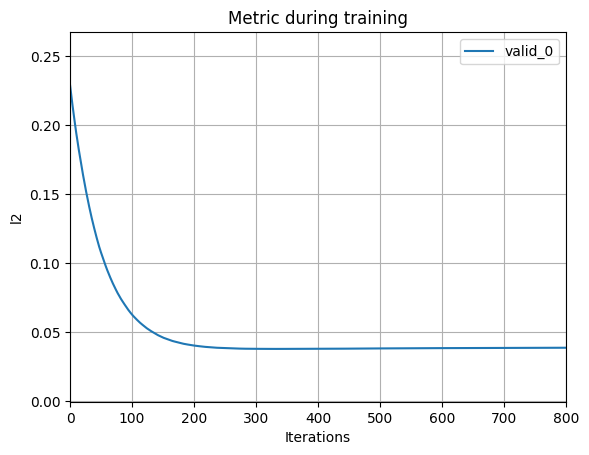

In [24]:
print('Plotting metrics recorded during training...')
ax = lgb.plot_metric(evals_result, metric='l2')
plt.show()

# 绘制分割值直方图（split value histogram）

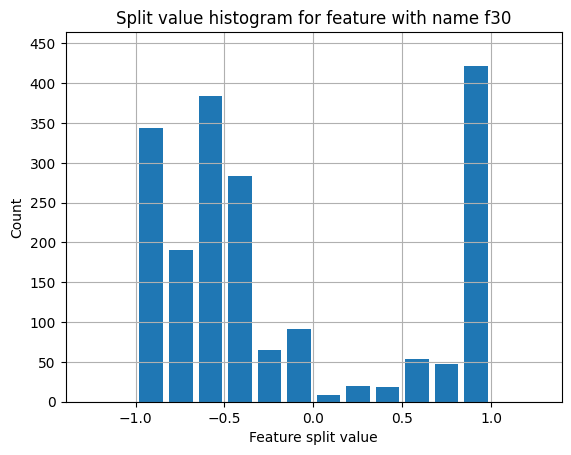

In [25]:
ax = lgb.plot_split_value_histogram(lgbm, feature='f30', bins='auto')
plt.show()

# 绘制指定树

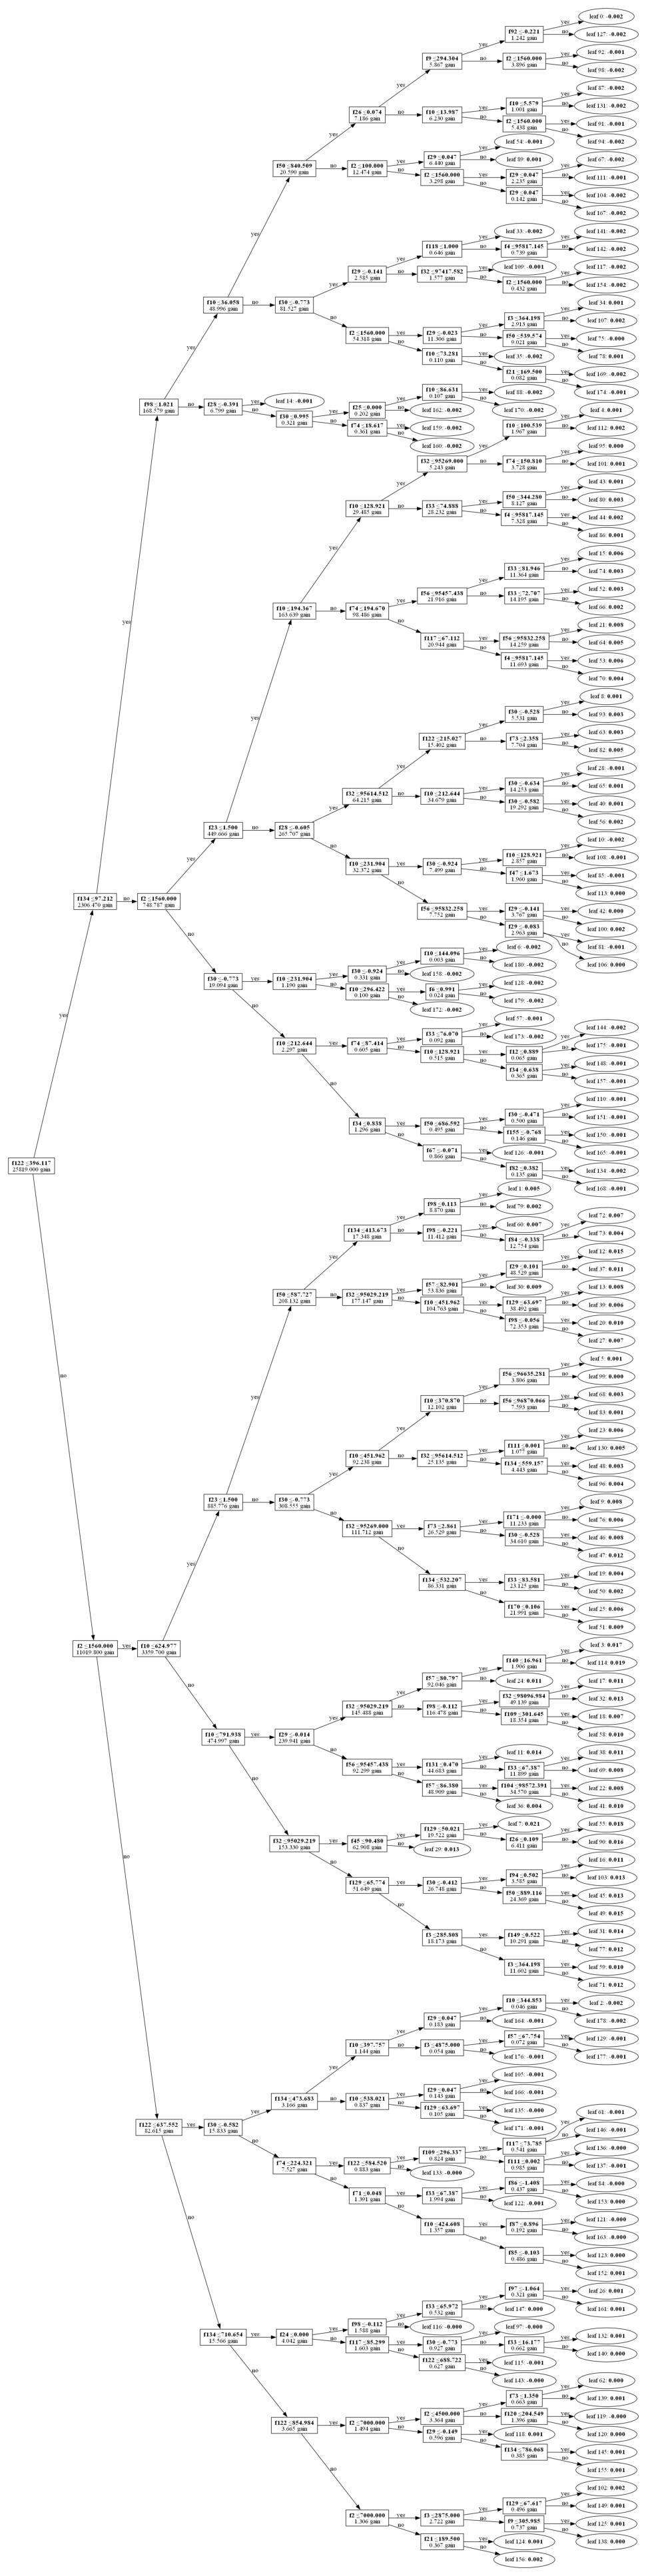

In [30]:
ax = lgb.plot_tree(lgbm, tree_index=3, figsize=(20,50), show_info=['split_gain'])
plt.show()

In [29]:
print('Plotting 54th tree with graphviz...')
graph = lgb.create_tree_digraph(lgbm, 
                                tree_index=3, 
                                name='Tree',
                                #orientation='optional'
                                )
graph.render(view=True)


Plotting 54th tree with graphviz...


'Tree.gv.pdf'

In [23]:
df_importance = pd.DataFrame({
    'column': feats,
    'importance': lgbm.feature_importance(),
})
display(df_importance.sort_values('importance', ascending=False).reset_index(drop=True))


,column,importance
0,ID,1822
1,irradiation_intensity_J/m2,1800
2,cos_hour_minute_rad,1675
3,install_capacity,1450
4,hour_minute,1327
...,...,...
170,wind_dir_10m_degree_diff1_gby_hour_skew,7
171,wind_dir_10m_degree_diff1_gby_hour_mean,6
172,wind_dir_100m_degree_diff1_gby_hour_skew,5
173,wind_dir_10m_degree_diff1,2


In [26]:
# pred = lgbm.predict(Xvl)
# score = 1 / (1 + mean_squared_error(valid['target'], pred, squared=False))
# score

In [25]:
Xtr = train_data_pldf[feats].to_numpy()
Ytr = train_data_pldf['target'].to_numpy()
#params['num_iterations'] = lgbm.best_iteration
lgbm = lgb.LGBMRegressor(**params, random_state=42)
lgbm = lgb.train(params, lgb.Dataset(Xtr, Ytr))
pred = lgbm.predict(test_data[feats])

In [67]:
test_data['pred'] = pred
df = test_data[['ID', 'magnifying_power', 'date_time', 'pred']]
df['day'] = df['date_time'].astype(str).apply(lambda x: x.split()[0])
df = df.groupby(['ID', 'day'])['pred'].agg(list).to_frame(name='pred').reset_index()

def format_datetime(x):
    year, month, day = x.split('-')
    if month.startswith('0'):
        month = month.replace('0', '')
    if day.startswith('0'):
        day = day.replace('0', '')
    return '-'.join([year, month, day]) + ' 0:00'

df['时间'] = df['day'].apply(format_datetime)
df['光伏用户编号'] = df['ID'].apply(lambda x: f'f{x}')

In [68]:
subm_data = []
for _, row in tqdm(df.iterrows(), total=len(df)):
    di = {'光伏用户编号': row["光伏用户编号"], '时间': row['时间']}
    for i, p in enumerate(row['pred']):
        di[f'p{i+1}'] = p
    subm_data.append(di)
subm_data = pd.DataFrame(subm_data)
sub = pd.read_csv('submit_example.csv')
sub = sub[['光伏用户编号', '综合倍率', '时间']].merge(subm_data, on=['光伏用户编号', '时间'], how='left')
display(sub)

  0%|          | 0/825 [00:00<?, ?it/s]

,光伏用户编号,综合倍率,时间,p1,p2,p3,p4,p5,p6,p7,...,p87,p88,p89,p90,p91,p92,p93,p94,p95,p96
0,f1,80,2023-5-1 0:00,-0.000213,-0.000213,-0.000213,-0.000213,-0.000177,-0.000177,-0.000177,...,-0.000246,-0.000246,-0.000231,-0.000231,-0.000224,-0.000224,-0.001417,-0.001417,-0.001362,-0.001362
1,f1,80,2023-5-2 0:00,-0.001882,-0.001882,-0.001882,-0.001882,-0.001035,-0.001725,-0.002162,...,-0.000299,-0.000299,-0.000544,-0.000544,-0.000537,-0.000537,-0.000192,-0.000108,-0.000069,-0.000213
2,f1,80,2023-5-3 0:00,-0.000594,-0.000594,-0.000594,-0.000523,-0.000467,-0.000931,-0.001368,...,-0.001391,-0.001391,-0.001363,-0.001363,-0.001361,-0.001361,-0.001330,-0.001246,-0.001208,-0.001208
3,f1,80,2023-5-4 0:00,-0.001476,-0.001476,-0.001476,-0.001476,-0.001581,-0.001581,-0.001784,...,-0.001782,-0.001782,-0.000936,-0.000936,-0.000934,-0.000934,-0.002060,-0.001976,-0.001921,-0.001921
4,f1,80,2023-5-5 0:00,-0.000495,-0.000495,-0.000495,-0.000495,-0.000519,-0.000519,-0.000519,...,0.001155,0.001155,0.000278,0.000278,0.000280,0.000280,0.000280,0.000280,0.000318,0.000318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820,f9,8000,2023-7-27 0:00,0.000287,0.000287,0.000287,0.000287,0.000294,0.000294,0.000294,...,0.000071,0.000082,0.000711,0.000776,0.000784,0.000784,0.000338,0.000338,0.000257,0.000257
821,f9,8000,2023-7-30 0:00,-0.000692,-0.000692,-0.000692,-0.000692,-0.000682,-0.000682,-0.000682,...,-0.000543,-0.000543,-0.000583,-0.000583,-0.000581,-0.000581,-0.000528,-0.000528,-0.000543,-0.000543
822,f9,8000,2023-7-31 0:00,-0.000397,-0.000397,-0.000397,-0.000397,-0.001583,-0.001583,-0.001583,...,-0.001467,-0.001467,-0.001277,-0.001277,-0.001270,-0.001270,-0.000771,-0.000771,-0.000787,-0.000787
823,f9,8000,2023-5-15 0:00,-0.001365,-0.001365,-0.001365,-0.001365,-0.001109,-0.001109,-0.001109,...,-0.000770,-0.000770,-0.001456,-0.001456,-0.001449,-0.001449,-0.001013,-0.001013,-0.001029,-0.001029


In [69]:
sub.to_csv(f'lgb_{score}.csv', index=False)